In [13]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [14]:
path = "./"
path = "C:/temp/kaggle/webeconomics/"


train = pd.read_csv(path+"train.csv")
validation = pd.read_csv(path+"validation.csv")

In [15]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [17]:
# lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
# rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
#xgb_preds = pd.read_csv(path+"Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
dwane_preds = pd.read_csv(path+"Prediction_csv/click_predictions_narrow.csv")
lasso_preds = pd.read_csv(path+"Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")
# ridge_preds = pd.read_csv("Prediction_csv/ridge_basebid.csv", index_col  = "Unnamed: 0")
# elasticnet_preds = pd.read_csv("Prediction_csv/elasticnet_basebid.csv", index_col  = "Unnamed: 0")
# rfg_preds = pd.read_csv("Prediction_csv/rfg_basebid.csv", index_col  = "Unnamed: 0")
#xgbr_preds = pd.read_csv("Prediction_csv/xgb_basebid.csv", index_col  = "Unnamed: 0")

In [25]:
dwane_preds.head(16)


dwane_preds["click_proba"] = dwane_preds["pCTR"]




# Strategy

In [42]:
def Strategy3(sub_pCTR, sub_basebid, thresh):
    avgCTR = sub_pCTR["click_proba"].mean()
    sub_pCTR_ = sub_pCTR.copy()
    sub_pCTR_["click_proba"] = sub_pCTR_["click_proba"].map(lambda x: 0 if x > thresh else np.exp(x))
    bidprice = (sub_pCTR_["click_proba"] * sub_basebid["predicted_payprice"]) / avgCTR
    return bidprice

def Strategy4(sub_pCTR, sub_basebid, thresh1  ):
    thresh2 = thresh1 + 0.1
    avgCTR = sub_pCTR["click_proba"].mean()
    sub_pCTR_ = sub_pCTR.copy()
    sub_pCTR_["click_proba"] = sub_pCTR_["click_proba"].map(lambda x: 0 if (x >= thresh1) and (x < thresh2) else np.exp(x))
    bidprice = (sub_pCTR_["click_proba"] * sub_basebid["predicted_payprice"]) / avgCTR
    return bidprice

In [43]:
thresh_pCTR = np.linspace(0.0, 1.0, 11)
thresh_pCTR

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

# Evaluate Results

In [44]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid, thresh):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["basebid_predicted"] = submission_basebid["predicted_payprice"]
    validation_check["bidprice_predicted"] = Strategy4(submission_pCTR, submission_basebid, thresh)
    
    return validation_check

def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                
                impressions+=1
                clicks+=row[1]["click"]
                cost+=row[1]["payprice"]
                balance-=row[1]["payprice"]
                
#                 if (balance > row[1]["bidprice_predicted"]):
                    
#                     impressions+=1
#                     clicks+=row[1]["click"]
#                     cost+=row[1]["payprice"]
#                     balance-=row[1]["payprice"]
#                 else:
#                     pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [45]:
pCTR_model_name = "Dwanev1"
results = pd.DataFrame(columns = ["pCTR thresh", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0

start = time.time()

for thresh in thresh_pCTR:
    
    validation_check = ValidationDataFrame(dwane_preds, lasso_preds, thresh)
    print("\033[1m pCTR model: {} \033[0m, \033[1m Basebid model: {} \033[0m, \033[1m thresh: {} \033[0m".format("XGBoost", "Lasso", thresh))
    impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
    results.loc[i] = [thresh, impressions, clicks, cost, ctr, cpm, cpc]
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.0 
Strategy statistics:
Auctions participated: 242853 | Impressions: 71364 | Clicks: 132 | Cost: 6250082 | CTR: 0.18497 | CPM: 87.58032 | CPC: 47.35


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.1 
Strategy statistics:
Auctions participated: 85383 | Impressions: 80085 | Clicks: 54 | Cost: 6250003 | CTR: 0.06743 | CPM: 78.04212 | CPC: 115.74


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.2 
Strategy statistics:
Auctions participated: 85346 | Impressions: 80336 | Clicks: 52 | Cost: 6250015 | CTR: 0.06473 | CPM: 77.79843 | CPC: 120.19


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.30000000000000004 
Strategy statistics:
Auctions participated: 79727 | Impressions: 79720 | Clicks: 51 | Cost: 6250001 | CTR: 0.06397 | CPM: 78.39941 | CPC: 122.55


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.4 
Strategy statistics:
Auctions participated: 81780 | Impressions: 80046 | Clicks: 49 | Cost

In [46]:
results.to_csv("ValidationSet_Evaluation_Results_Individual_"+pCTR_model_name+"_lasso_pCTRthresh.csv")

In [47]:
results.sort_values(by = ["CTR"], ascending = False)

,pCTR thresh,Impressions,Clicks,Cost,CTR,CPM,CPC
0,0.0,71364.0,132.0,6250082.0,0.184967,87.580321,47.349106
1,0.1,80085.0,54.0,6250003.0,0.067428,78.042118,115.740796
8,0.8,80009.0,52.0,6250033.0,0.064993,78.116624,120.192942
2,0.2,80336.0,52.0,6250015.0,0.064728,77.798434,120.192596
3,0.3,79720.0,51.0,6250001.0,0.063974,78.399410,122.549039
7,0.7,79720.0,51.0,6250001.0,0.063974,78.399410,122.549039
6,0.6,79907.0,51.0,6250087.0,0.063824,78.217015,122.550725
9,0.9,79981.0,51.0,6250045.0,0.063765,78.144122,122.549902
5,0.5,80001.0,49.0,6250020.0,0.061249,78.124273,127.551429
4,0.4,80046.0,49.0,6250009.0,0.061215,78.080216,127.551204


In [48]:
results.to_latex('./results.txt')

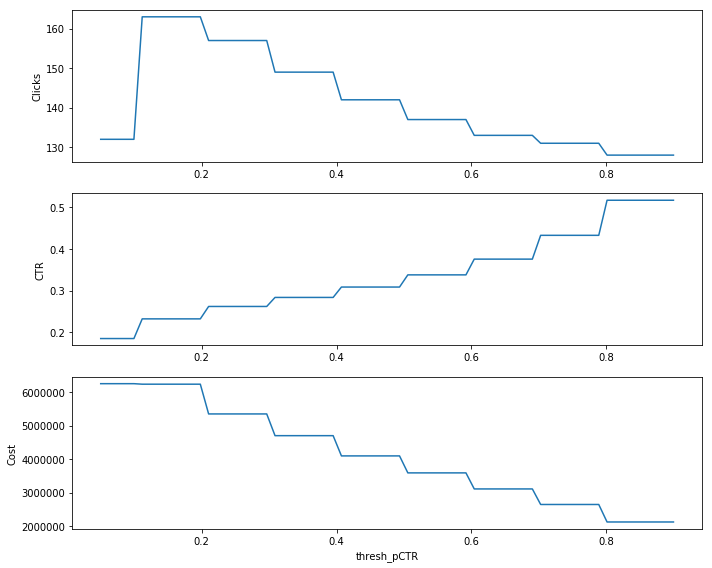

In [34]:
plt.figure(figsize = (10,8))

plt.subplot(3,1,1)
plt.plot(thresh_pCTR, results["Clicks"])
plt.ylabel("Clicks")

plt.subplot(3,1,2)
plt.plot(thresh_pCTR, results["CTR"])
plt.ylabel("CTR")

plt.subplot(3,1,3)
plt.plot(thresh_pCTR, results["Cost"])
plt.ylabel("Cost")
plt.xlabel("thresh_pCTR")

plt.tight_layout()
plt.savefig('./varying_pCTR.png')

In [35]:
run_1_thresh_pCTR = thresh_pCTR
run_1_clicks = results["Clicks"]
run_1_ctr = results["CTR"]
run_1_cost = results["Cost"]



